Given information about the simulation domain as well as user inputs, create the AMR-Wind sampling configuration info to simulate multiple concurrent field campaigns

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
def round_to_grid_lo(val, dx):
    '''
    Ground a value to the nearest low whole value
    E.g. val=121, dx=10, return 120
    '''
    return np.floor(val/dx) * dx

def round_to_grid_hi(val, dx):
    '''
    Ground a value to the nearest low whole value
    E.g. val=121, dx=10, return 130
    '''
    return np.ceil(val/dx) * dx

# Inputs as well as light calculations

In [3]:
### Simulation inputs
prob_lox, prob_loy, prob_loz = 0.0, 0.0, 0.0
prob_hix, prob_hiy, prob_hiz = 15360.0, 15360.0, 1280.0
n_cellx, n_celly, n_cellz = 1536, 1536, 128
amr_dt = 0.5

In [4]:
### Calculated simulation parameters
dx_amr, dy_amr, dz_amr = prob_hix/n_cellx, prob_hiy/n_celly, prob_hiz/n_cellz

In [5]:
### Inputs specificly for sampling planes
## Turbine parameters
### User inputs
# turb_x = [1280.0, 1280.0, 1280.0]
# turb_y = [640.0, 1280.0, 1920.0]
turb_D = 127.0
turb_hub_height = 117.0

## Inflow boundary condition plane
bc_Ly, bc_Lz = 640.0, 640.0
assert bc_Ly % dy_amr == 0, "Inflow boundary condition plane width should be a multiple of the y-grid resolution!"
assert bc_Lz % dz_amr == 0, "Inflow boundary condition plane height should be a multiple of the z-grid resolution!"

## Inflow lidar
in_drange = 12.0
in_L = round_to_grid_lo(1000, in_drange)

in_sampling_time = 1.0   # Time spent at each beam
assert in_sampling_time % amr_dt == 0, "Inflow lidar sampling time must be a multiple of the AMR-Wind simulation timestep!"
in_n_meas_per_loc = int(in_sampling_time/amr_dt)    
in_sweep_time = 15.0
in_sweep_bonus_time = in_sampling_time - amr_dt  # We add extra timesteps at the last beam to match the measurent time of the other beams
in_reset_time = 3.0
assert in_sweep_time % in_sweep_time == 0, f"The input sweep time for the inflow lidar {in_sweep_time} needs to be a multiple of the time spent at each beam {in_sampling_time}"

in_daz = 2.0
in_az_half_angle = 15
in_az_increase_flag = False
in_az_start = 195.0
# TODO: I am hardcoding the elevation sweep values at 0.0 for now

## Outflow lidar
out_drange = 12.0
out_L = round_to_grid_lo(1000, in_drange)
    
out_sampling_time = 1.0   # Time spent at each beam
assert out_sampling_time % amr_dt == 0, "Outflow lidar sampling time must be a multiple of the AMR-Wind simulation timestep!"
out_n_meas_per_loc = int(out_sampling_time/amr_dt)    
out_sweep_time = 15.0
out_sweep_bonus_time = out_sampling_time - amr_dt  # We add extra timesteps at the last beam to match the measurent time of the other beams
out_reset_time = 3.0
assert out_sweep_time % out_sweep_time == 0, f"The input sweep time for the outflow lidar {out_sweep_time} needs to be a multiple of the time spent at each beam {out_sampling_time}"

out_daz = 2.0
out_az_half_angle = 15
out_az_increase_flag = True
out_az_start = -15.0
# TODO: I am hardcoding the elevation sweep values at 0.0 for now

# Calculate locations for turbines

In [6]:
# ### Calculate locations for turbines
# ###   Note: For the LDM, we only care about the inflow BC and the inflow lidar,
# ###         not the outflow lidar, so we can ignore that instrument here
# ## Prepare info about spacing
# x_spacing = max(bc_Ly, round_to_grid_hi(2 * in_L * np.sin(np.deg2rad(in_az_half_angle)), dx_amr))
# y_spacing = 1000.0 # in_L

# # nx_max_per_row = np.floor((prob_hix-prob_lox)/x_spacing).astype(int)
# # ny_max_per_col = np.floor((prob_hiy-prob_loy)/y_spacing).astype(int)
# # nx_per_row = nx_max_per_row - 1  # We will shift campaigns along this direction
# # ny_per_col = ny_max_per_col

# # Buffer to side of domain
# buffer_xlo = x_spacing / 2 + 20
# buffer_xhi = x_spacing / 2 + 20
# # shift_x = x_spacing / 4
# shifts_x = [0, x_spacing/4, x_spacing/2, 3*x_spacing/4]

# x0_turbs = buffer_xlo
# y0_turbs = y_spacing + 120
# ymax_turbs = prob_hiy

# ## Calculate turbine locations
# turb_x = []
# turb_y = []

# curr_x, curr_y = x0_turbs, y0_turbs
# xshift_counter = 1
# while curr_y < ymax_turbs:
#     while curr_x < prob_hix-buffer_xhi:
#         # print(curr_x, curr_y)

#         turb_x.append(curr_x)
#         turb_y.append(curr_y)
        
        
#         curr_x += x_spacing
#     curr_x = x0_turbs + shifts_x[xshift_counter % len(shifts_x)]
#     curr_y += y_spacing
#     xshift_counter += 1
    
# print('x locations:', turb_x, '\n')
# print('y locations:', turb_y)

In [7]:
### Calculate locations for turbines
###   Note: For the LDM, we only care about the inflow BC and the inflow lidar,
###         not the outflow lidar, so we can ignore that instrument here
## Prepare info about spacing
x_spacing = 1000.0 # in_L
y_spacing = max(bc_Ly, round_to_grid_hi(2 * in_L * np.sin(np.deg2rad(in_az_half_angle)), dy_amr))

# nx_max_per_row = np.floor((prob_hix-prob_lox)/x_spacing).astype(int)
# ny_max_per_col = np.floor((prob_hiy-prob_loy)/y_spacing).astype(int)
# nx_per_row = nx_max_per_row - 1  # We will shift campaigns along this direction
# ny_per_col = ny_max_per_col

# Buffer to side of domain
buffer_ylo = y_spacing / 2 + 20
buffer_yhi = y_spacing / 2 + 20
# shift_y = y_spacing / 4
shifts_y = [0, y_spacing/4, y_spacing/2, 3*y_spacing/4]

x0_turbs = x_spacing + 120
y0_turbs = buffer_ylo
xmax_turbs = prob_hix

## Calculate turbine locations
turb_x = []
turb_y = []

curr_x, curr_y = x0_turbs, y0_turbs
yshift_counter = 1

while curr_x < xmax_turbs:
    while curr_y < prob_hiy-buffer_yhi:
        # print(curr_x, curr_y)

        turb_x.append(curr_x)
        turb_y.append(curr_y)
        
        
        curr_y += y_spacing
    curr_y = y0_turbs + shifts_y[yshift_counter % len(shifts_y)]
    curr_x += x_spacing
    yshift_counter += 1
    
print('x locations:', turb_x, '\n')
print('y locations:', turb_y)

x locations: [1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 1120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 2120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 3120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 4120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 5120.0, 6120.0, 6120.0, 6120.0, 6120.0, 6120.0, 6120.0, 6120.0, 6120.0, 61

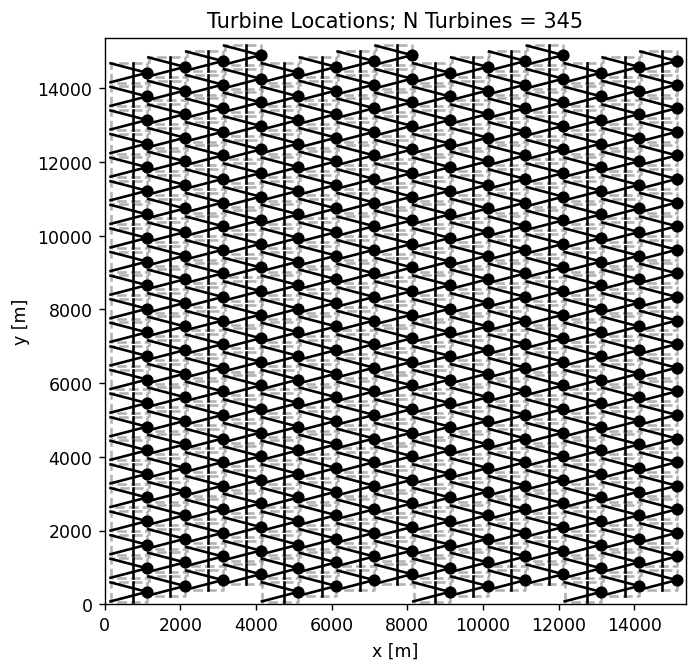

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=125)

ax.set_xlim(prob_lox, prob_hix)
ax.set_ylim(prob_loy, prob_hiy)

for i in range(len(turb_x)):
    ax.scatter([turb_x[i]], [turb_y[i]], color=f'k')
    
    ## Plot the bounding box of interest
    xs0 = [turb_x[i]-x_spacing+50, turb_x[i]-x_spacing+50, turb_x[i], turb_x[i], turb_x[i]-x_spacing+50]
    ys0 = [turb_y[i]-y_spacing/2+50, turb_y[i]+y_spacing/2-50, turb_y[i]+y_spacing/2-50, turb_y[i]-y_spacing/2+50, turb_y[i]-y_spacing/2+50]
    ax.plot(xs0, ys0, color=f'k', ls='--', alpha=0.3)
    
    ## Plot the BC plane
    xs1 = [turb_x[i]-3*turb_D, turb_x[i]-3*turb_D]
    ys1 = [turb_y[i]-bc_Ly/2+50, turb_y[i]+bc_Ly/2-50]
    ax.plot(xs1, ys1, color=f'k')
    
    ## Plot the upper branch of the lidars
    xs2 = [turb_x[i], turb_x[i]-in_L*np.cos(np.deg2rad(in_az_half_angle))]
    ys2 = [turb_y[i], turb_y[i]+in_L*np.sin(np.deg2rad(in_az_half_angle))]
    ax.plot(xs2, ys2, color=f'k')
    
    ## Plot the lower branch of the lidars
    xs3 = [turb_x[i], turb_x[i]-in_L*np.cos(np.deg2rad(in_az_half_angle))]
    ys3 = [turb_y[i], turb_y[i]-in_L*np.sin(np.deg2rad(in_az_half_angle))]
    ax.plot(xs3, ys3, color=f'k')
    
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title(f"Turbine Locations; N Turbines = {len(turb_x)}")

plt.savefig('schematic_campaigns_black.png', bbox_inches='tight', transparent=True)

plt.show()

In [11]:
### Create output for sampling
## ~~~~~~~~~~~~~~~ Common parameters ~~~~~~~~~~~~~~~
post_processing_list = []
post_processing_list.append('xy-domain')
for cnum in range(len(turb_x)):
    cid = str(cnum).zfill(4)
    cname = f'sampling{cid}'
    post_processing_list.append(cname)
post_processing_str = " ".join(post_processing_list)
print(f'incflo.post_processing                   = {post_processing_str}')

## Domain-wide xy-sampling
# Calculate parameters
xy_nx, xy_ny = n_cellx, n_celly
xy_Lx, xy_Ly = prob_hix-prob_lox-dx_amr, prob_hiy-prob_loy-dy_amr
xy_z = turb_hub_height + 3.0

# Write out
print()
print(f'# ------------- xy-plane sampling across the domain -------------')
print(f'xy-domain.output_frequency                = 1')
print(f'xy-domain.fields                          = velocity temperature tke')
print(f'xy-domain.labels                          = xy-domain')

print()
print(f'xy-domain.xy-domain.type                 = PlaneSampler')
print(f'xy-domain.xy-domain.num_points           = {xy_nx} {xy_ny}')
print(f'xy-domain.xy-domain.origin               = 0.0 0.0 {xy_z}')
print(f'xy-domain.xy-domain.axis1                = {xy_Lx} 0.0 0.0')
print(f'xy-domain.xy-domain.axis2                = 0.0 {xy_Ly} 0.0')

## ~~~~~~~~~~~~~~~ Create output for one turbine ~~~~~~~~~~~~~~~
for cnum in range(len(turb_x)):
    cid = str(cnum).zfill(4)
    cname = f'sampling{cid}'
    curr_turb_x = turb_x[cnum]
    curr_turb_y = turb_y[cnum]

    ## ~~~~~ Update for the broader incflo.post_processing class ~~~~~
    post_processing_list.append(cname)

    ## ~~~~~ Parameters common to all instruments in this campaign ~~~~~
    print()
    print(f'# ------------- Sampling parameters for one imaginary turbine at ({curr_turb_x} m, {curr_turb_y} m, 0.0 m) -------------')
    print(f'{cname}.output_frequency                = 1')
    print(f'{cname}.fields                          = velocity temperature tke')
    print(f'{cname}.labels                          = inflow-bc-3D inflow-bc-2p5D inflow-bc-2D met-mast inflow-scan outflow-scan')

    ## ~~~~~ The inflow boundary condtions, 3D~~~~~ 
    # Calculate parameters
    bc_ny, bc_nz = int(bc_Ly/dy_amr), int(bc_Lz/dz_amr)

    bc_upstream_offset = round_to_grid_lo(3*turb_D, dx_amr)
    bc_originx = float(curr_turb_x - bc_upstream_offset)
    bc_originy = float(curr_turb_y - (bc_Ly/2))
    bc_originz = 0.0

    bc_Ly_write, bc_Lz_write = bc_Ly - dy_amr, bc_Lz - dz_amr

    # Write out
    print()
    print(f'# Inflow boundary condition plane, 3D')
    print(f'{cname}.inflow-bc-3D.type               = PlaneSampler')
    print(f'{cname}.inflow-bc-3D.num_points         = {bc_ny} {bc_nz}')
    print(f'{cname}.inflow-bc-3D.origin             = {bc_originx} {bc_originy} {bc_originz}')
    print(f'{cname}.inflow-bc-3D.axis1              = 0.0 {bc_Ly_write} 0.0')
    print(f'{cname}.inflow-bc-3D.axis2              = 0.0 0.0 {bc_Lz_write}')
    
    ## ~~~~~ The inflow boundary condtions, 2.5D~~~~~ 
    # Calculate parameters
    bc_ny, bc_nz = int(bc_Ly/dy_amr), int(bc_Lz/dz_amr)

    bc_upstream_offset = round_to_grid_lo(2.5*turb_D, dx_amr)
    bc_originx = float(curr_turb_x - bc_upstream_offset)
    bc_originy = float(curr_turb_y - (bc_Ly/2))
    bc_originz = 0.0

    bc_Ly_write, bc_Lz_write = bc_Ly - dy_amr, bc_Lz - dz_amr

    # Write out
    print()
    print(f'# Inflow boundary condition plane, 2.5D')
    print(f'{cname}.inflow-bc-2p5D.type             = PlaneSampler')
    print(f'{cname}.inflow-bc-2p5D.num_points       = {bc_ny} {bc_nz}')
    print(f'{cname}.inflow-bc-2p5D.origin           = {bc_originx} {bc_originy} {bc_originz}')
    print(f'{cname}.inflow-bc-2p5D.axis1            = 0.0 {bc_Ly_write} 0.0')
    print(f'{cname}.inflow-bc-2p5D.axis2            = 0.0 0.0 {bc_Lz_write}')
    
    ## ~~~~~ The inflow boundary condtions, 2D~~~~~ 
    # Calculate parameters
    bc_ny, bc_nz = int(bc_Ly/dy_amr), int(bc_Lz/dz_amr)

    bc_upstream_offset = round_to_grid_lo(2*turb_D, dx_amr)
    bc_originx = float(curr_turb_x - bc_upstream_offset)
    bc_originy = float(curr_turb_y - (bc_Ly/2))
    bc_originz = 0.0

    bc_Ly_write, bc_Lz_write = bc_Ly - dy_amr, bc_Lz - dz_amr

    # Write out
    print()
    print(f'# Inflow boundary condition plane, 2D')
    print(f'{cname}.inflow-bc-2D.type               = PlaneSampler')
    print(f'{cname}.inflow-bc-2D.num_points         = {bc_ny} {bc_nz}')
    print(f'{cname}.inflow-bc-2D.origin             = {bc_originx} {bc_originy} {bc_originz}')
    print(f'{cname}.inflow-bc-2D.axis1              = 0.0 {bc_Ly_write} 0.0')
    print(f'{cname}.inflow-bc-2D.axis2              = 0.0 0.0 {bc_Lz_write}')

    ## ~~~~~ The met mast ~~~~~
    # Create the probe locations file
    with open(f"probe_locations{cid}.txt", 'w') as metfile:
        metfile.write(f'4\n')
        metfile.write(f'{bc_originx}  {curr_turb_y}  2.0\n')
        metfile.write(f'{bc_originx}  {curr_turb_y}  52.6\n')
        metfile.write(f'{bc_originx}  {curr_turb_y}  110.5\n')
        metfile.write(f'{bc_originx}  {curr_turb_y}  176.5\n')

    # Write out
    print()
    print(f'{cname}.met-mast.type                   = ProbeSampler')
    print(f'{cname}.met-mast.probe_location_file    = "probe_locations{cid}.txt"')

    ## ~~~~~ The inflow scanning lidar ~~~~~
    # Calculate parameters
    in_n_pts = int(in_L / in_drange)
    in_originx = curr_turb_x
    in_originy = curr_turb_y
    in_originz = xy_z

    if in_az_increase_flag:
        in_az_end = in_az_start + 2*in_az_half_angle
        in_az_range = np.arange(in_az_start, in_az_end+in_daz, in_daz)
    else:
        in_az_end = in_az_start - 2*in_az_half_angle
        in_az_range = np.arange(in_az_start, in_az_end-in_daz, -1*in_daz)

    in_sweep_interval_time = np.arange(0.0, in_sweep_time+in_sweep_bonus_time+amr_dt, amr_dt)
    in_reset_interval_time = np.array([in_sweep_interval_time[-1]+amr_dt, in_sweep_time+in_reset_time])
    in_time_table_arr = np.concatenate((in_sweep_interval_time, in_reset_interval_time))
    in_time_table_str = []
    for item in in_time_table_arr:
        in_time_table_str.append(f'{str(item):5s}')
    in_time_table_str = " ".join(in_time_table_str)

    in_az_sweep_table = []
    for curr_az in in_az_range:
        for repeats in range(in_n_meas_per_loc):
            in_az_sweep_table.append(curr_az)
    in_az_reset_flag = 0.0  # TODO: I should probably pick a different flag value
    in_az_reset_table = np.array([in_az_reset_flag, in_az_reset_flag])
    in_az_table_arr = np.concatenate((in_az_sweep_table, in_az_reset_table))
    in_az_table_str = []
    for item in in_az_table_arr:
        in_az_table_str.append(f'{str(item):5s}')
    in_az_table_str = " ".join(in_az_table_str)

    in_el_sweep_table = np.zeros_like(in_az_sweep_table)
    in_el_reset_flag = 45.0  # TODO: I should probably pick a different flag value
    in_el_reset_table = np.array([in_el_reset_flag, in_el_reset_flag])
    in_el_table_arr = np.concatenate((in_el_sweep_table, in_el_reset_table))
    in_el_table_str = []
    for item in in_el_table_arr:
        in_el_table_str.append(f'{str(item):5s}')
    in_el_table_str = " ".join(in_el_table_str)

    # Write out
    print()
    print(f'{cname}.inflow-scan.type                = LidarSampler')
    print(f'{cname}.inflow-scan.num_points          = {in_n_pts}    # Range gate resolution of {in_drange} m')
    print(f'{cname}.inflow-scan.length              = {in_L}')
    print(f'{cname}.inflow-scan.origin              = {in_originx} {in_originy} {in_originz}  # Lidar situated {in_originz-turb_hub_height} m above hub height')
    print(f'{cname}.inflow-scan.periodic            = true')
    print(f'{cname}.inflow-scan.time_table          = {in_time_table_str}')
    print(f'{cname}.inflow-scan.azimuth_table       = {in_az_table_str}')
    print(f'{cname}.inflow-scan.elevation_table     = {in_el_table_str}')

    ## ~~~~~ The outflow scanning lidar ~~~~~
    # Calculate parameters
    out_n_pts = int(out_L / out_drange)
    out_originx = curr_turb_x
    out_originy = curr_turb_y
    out_originz = turb_hub_height + 3.0

    if out_az_increase_flag:
        out_az_end = out_az_start + 2*out_az_half_angle
        out_az_range = np.arange(out_az_start, out_az_end+out_daz, out_daz)
    else:
        out_az_end = out_az_start - 2*out_az_half_angle
        out_az_range = np.arange(out_az_start, out_az_end-out_daz, -1*out_daz)

    out_sweep_interval_time = np.arange(0.0, out_sweep_time+out_sweep_bonus_time+amr_dt, amr_dt)
    out_reset_interval_time = np.array([out_sweep_interval_time[-1]+amr_dt, out_sweep_time+out_reset_time])
    out_time_table_arr = np.concatenate((out_sweep_interval_time, out_reset_interval_time))
    out_time_table_str = []
    for item in out_time_table_arr:
        out_time_table_str.append(f'{str(item):5s}')
    out_time_table_str = " ".join(out_time_table_str)

    out_az_sweep_table = []
    for curr_az in out_az_range:
        for repeats in range(out_n_meas_per_loc):
            out_az_sweep_table.append(curr_az)
    out_az_reset_flag = 0.0  # TODO: I should probably pick a different flag value
    out_az_reset_table = np.array([out_az_reset_flag, out_az_reset_flag])
    out_az_table_arr = np.concatenate((out_az_sweep_table, out_az_reset_table))
    out_az_table_str = []
    for item in out_az_table_arr:
        out_az_table_str.append(f'{str(item):5s}')
    out_az_table_str = " ".join(out_az_table_str)

    out_el_sweep_table = np.zeros_like(out_az_sweep_table)
    out_el_reset_flag = 45.0  # TODO: I should probably pick a different flag value
    out_el_reset_table = np.array([out_el_reset_flag, out_el_reset_flag])
    out_el_table_arr = np.concatenate((out_el_sweep_table, out_el_reset_table))
    out_el_table_str = []
    for item in out_el_table_arr:
        out_el_table_str.append(f'{str(item):5s}')
    out_el_table_str = " ".join(out_el_table_str)

    # Write out
    print()
    print(f'{cname}.outflow-scan.type               = LidarSampler')
    print(f'{cname}.outflow-scan.num_points         = {out_n_pts}    # Range gate resolution of {out_drange} m')
    print(f'{cname}.outflow-scan.length             = {out_L}')
    print(f'{cname}.outflow-scan.origin             = {out_originx} {out_originy} {out_originz}  # Lidar situated {out_originz-turb_hub_height} m above hub height')
    print(f'{cname}.outflow-scan.periodic           = true')
    print(f'{cname}.outflow-scan.time_table         = {out_time_table_str}')
    print(f'{cname}.outflow-scan.azimuth_table      = {out_az_table_str}')
    print(f'{cname}.outflow-scan.elevation_table    = {out_el_table_str}')

incflo.post_processing                   = xy-domain sampling0000 sampling0001 sampling0002 sampling0003 sampling0004 sampling0005 sampling0006 sampling0007 sampling0008 sampling0009 sampling0010 sampling0011 sampling0012 sampling0013 sampling0014 sampling0015 sampling0016 sampling0017 sampling0018 sampling0019 sampling0020 sampling0021 sampling0022 sampling0023 sampling0024 sampling0025 sampling0026 sampling0027 sampling0028 sampling0029 sampling0030 sampling0031 sampling0032 sampling0033 sampling0034 sampling0035 sampling0036 sampling0037 sampling0038 sampling0039 sampling0040 sampling0041 sampling0042 sampling0043 sampling0044 sampling0045 sampling0046 sampling0047 sampling0048 sampling0049 sampling0050 sampling0051 sampling0052 sampling0053 sampling0054 sampling0055 sampling0056 sampling0057 sampling0058 sampling0059 sampling0060 sampling0061 sampling0062 sampling0063 sampling0064 sampling0065 sampling0066 sampling0067 sampling0068 sampling0069 sampling0070 sampling0071 sampling007